In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read file
icfes = pd.read_csv("./data/icfes_preprocessing.csv", low_memory=False, encoding="utf-8")

print(icfes.shape)

(554679, 67)


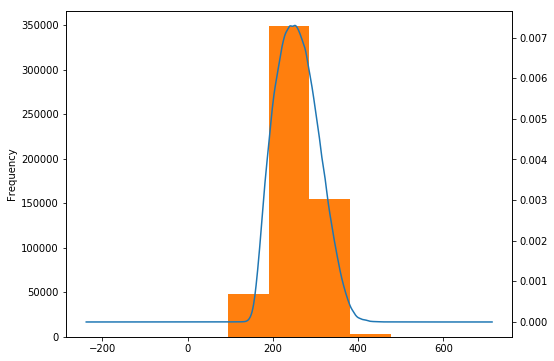

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
column = icfes['PUNT_GLOBAL']

column.plot.density(ax=ax1, secondary_y=True)

column.plot.hist(bins=5, ax=ax1)

plt.show()

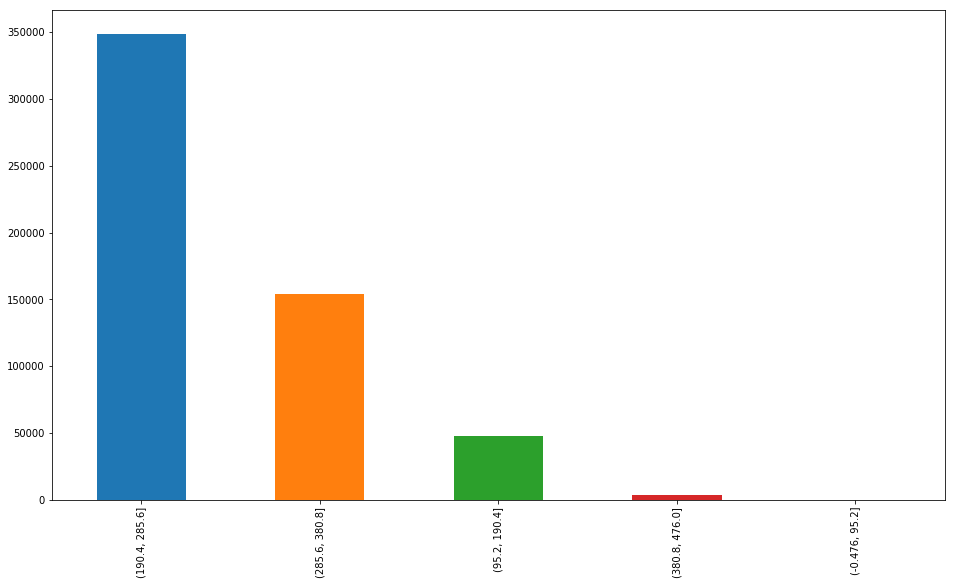

In [4]:
pg = pd.cut(icfes['PUNT_GLOBAL'], bins=5)

plt.figure(figsize=(16, 9))
pg.value_counts(dropna=False).plot.bar()

# Preprocessing

In [60]:
import math
from sklearn import preprocessing

m = math.ceil(icfes.shape[0]*1)

data = icfes.iloc[0: m, :]

n = data.shape[1]

X = data.drop(columns='PUNT_GLOBAL')
y = data['PUNT_GLOBAL']

print(data.shape)


# Remove unused columns
X = X.drop(columns=['PERCENTIL_C_NATURALES',
                    'PERCENTIL_GLOBAL',
                    'PERCENTIL_INGLES',
                    'PERCENTIL_LECTURA_CRITICA',
                    'PERCENTIL_MATEMATICAS',
                    'PERCENTIL_SOCIALES_CIUDADANAS'])
X = X[X.columns[X.columns.to_series().str.contains('FAMI')]]

# One-hot enconding
X = pd.get_dummies(X)
X_labels = X.columns
X = X.values

# Discretization
y = pd.cut(y, bins=5).astype(str)


# Enconding
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y)
y_labels = le.classes_
print(y_labels)

y.describe(include='all')

y.info()

y = y.values

print(X.shape)
print(y.shape)

y_labels

(554679, 67)
['(-0.476, 95.2]' '(190.4, 285.6]' '(285.6, 380.8]' '(380.8, 476.0]'
 '(95.2, 190.4]']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554679 entries, 0 to 554678
Data columns (total 1 columns):
0    554679 non-null int64
dtypes: int64(1)
memory usage: 4.2 MB
(554679, 124)
(554679, 1)


array(['(-0.476, 95.2]', '(190.4, 285.6]', '(285.6, 380.8]',
       '(380.8, 476.0]', '(95.2, 190.4]'], dtype=object)

In [61]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X, y)

print(clf_tree.predict(X[4:8]))

print(y[4:8].reshape(1, -1))

[2 2 2 1]
[[2 2 2 1]]


In [62]:
import graphviz
import pydot

# Plot tree
dot_file = 'tree.dot'
dot_data = tree.export_graphviz(clf_tree, out_file=dot_file, 
                                feature_names=X_labels,  
                                class_names=y_labels,
                                max_depth = 4,
                                filled=True, proportion=True, rounded=True) 
graph = graphviz.Source(dot_data) 

(g,) = pydot.graph_from_dot_file(dot_file)
g.write_svg('tree.svg')

/home/juan/Programas/Miniconda3/envs/dm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


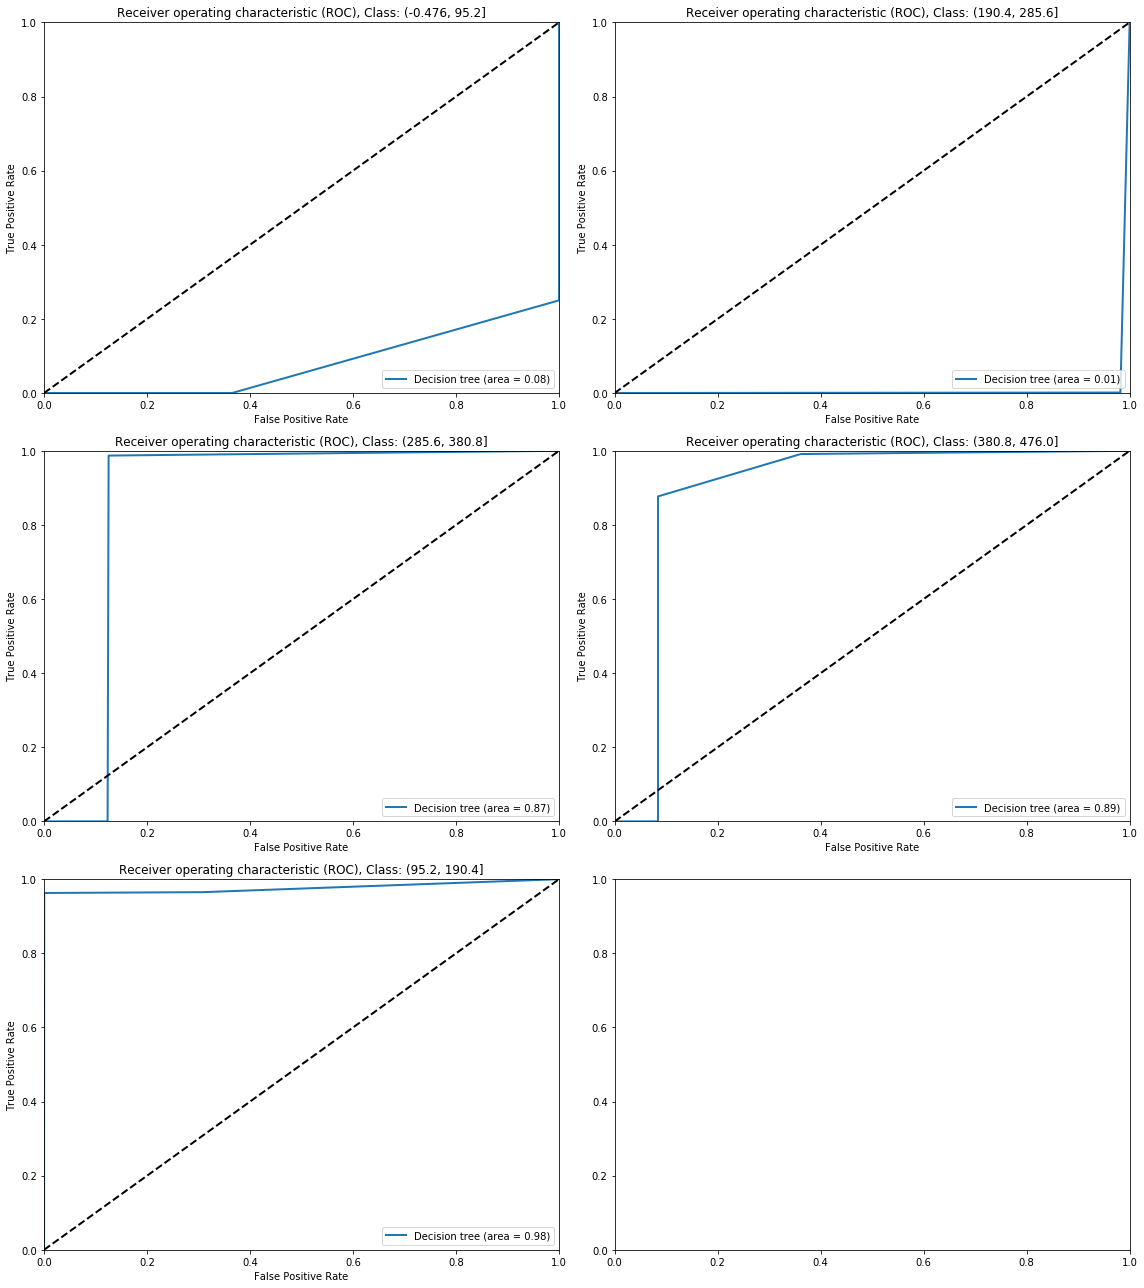

True

In [63]:
from sklearn.metrics import roc_curve, auc
# ROC

def ROC(clfs, clf_names, X, y, y_labels):
    
    r, c = (3, 2)
    fig, axes = plt.subplots(r, c, figsize=(8*c, 6*r))
    
    for clf, name in zip(clfs, clf_names):
        y_pred = clf.predict(X)

        fprs = []
        tprs = []
        aucs = []
        labels = []
        y_unique_values = np.unique(y)
        # Calc ROC
        for i in y_unique_values:
            fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=i)
            roc_auc = auc(fpr, tpr)
            fprs.append(fpr)
            tprs.append(tpr)
            aucs.append(roc_auc)
            labels.append(y_labels[i])

        # Plot ROC
        plot_num = 1
        lw = 2
        for label, fpr, tpr, roc_auc in zip(labels, fprs, tprs, aucs):
            ax = plt.subplot(r, c, plot_num)
            plot_num +=1

            ax.plot(fpr, tpr,
                 lw=lw, label='{} (area = {:0.2f})'.format(name, roc_auc))
    # Polish plot
    for plot_num, label in enumerate(labels):
        ax = plt.subplot(r, c, plot_num+1)
        ax.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic (ROC), Class: {}'.format(label))
        ax.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    return True


clfs = [clf_tree]
clf_names = ['Decision tree']
ROC(clfs, clf_names, X, y, y_labels)

/home/juan/Programas/Miniconda3/envs/dm/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[2 2 2 1]
[[2 2 2 1]]


/home/juan/Programas/Miniconda3/envs/dm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


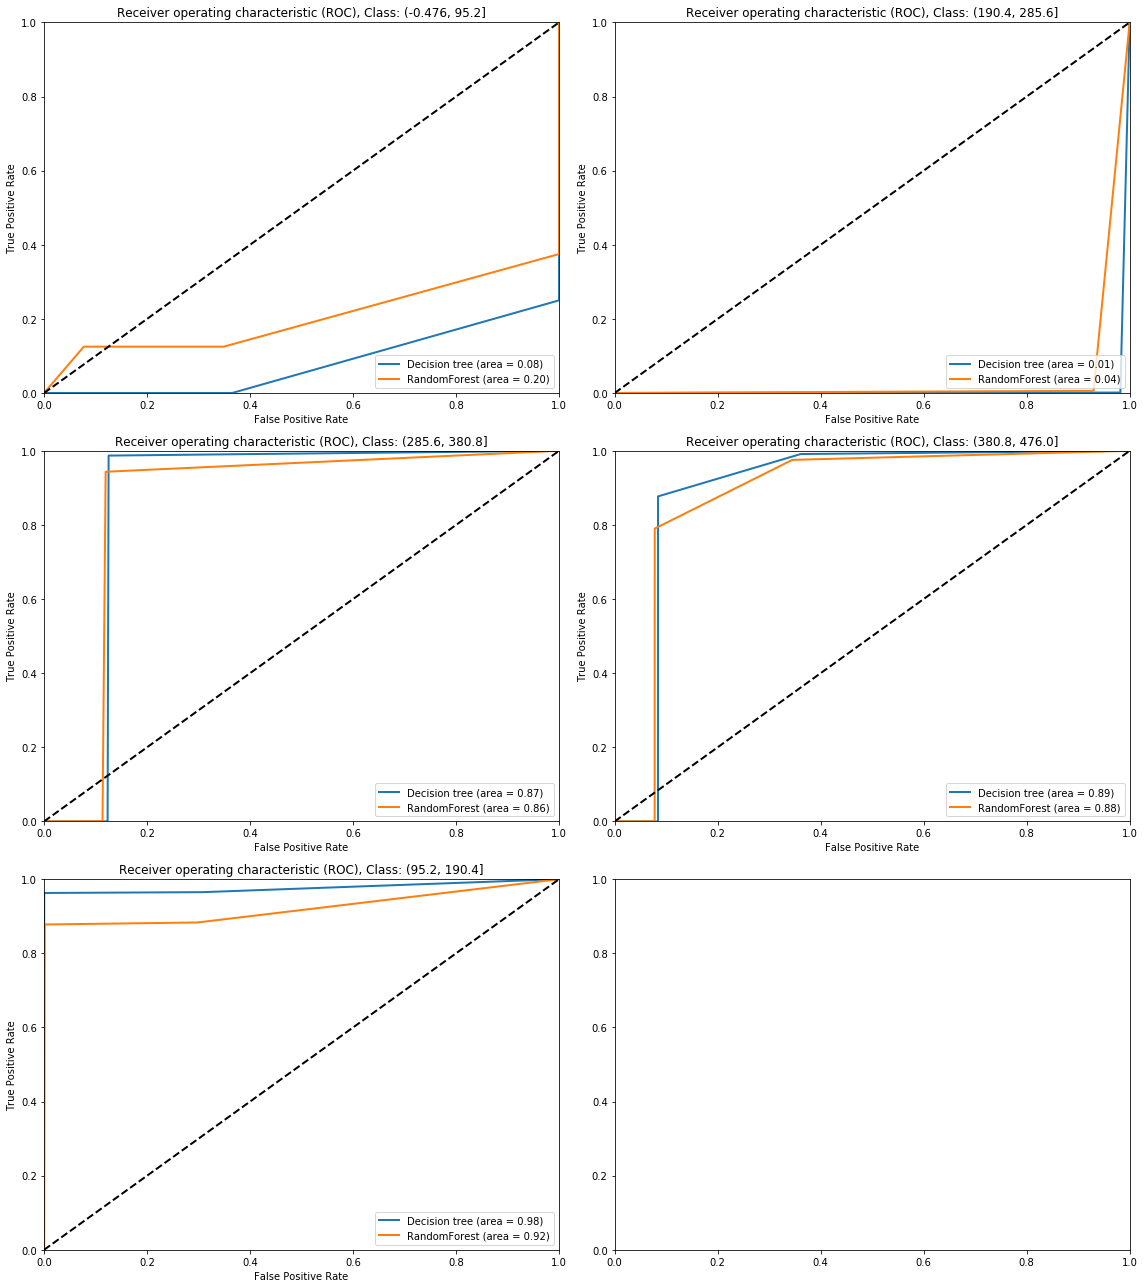

True

In [78]:
from sklearn.ensemble import RandomForestClassifier

trees = 10
max_depth = None

clf_RF = RandomForestClassifier(n_estimators=trees, max_depth=max_depth, n_jobs=-1)

clf_RF = clf_RF.fit(X, y)

print(clf_RF.predict(X[4:8]))

print(y[4:8].reshape(1, -1))

clfs = [clf_tree, clf_RF]
clf_names = ['Decision tree', 'RandomForest']
ROC(clfs, clf_names, X, y, y_labels)